In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from tqdm import tqdm

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Import DataLoader to extract dataset
from data_loader import DataLoader

# Initialize and extract dataset
data_loader = DataLoader()
data_loader.extract_dataset()

2026-01-17 17:47:49,604 [INFO] DataLoader: Data directory set to: C:\Users\jackb\source\repos\Automated_Material_Recognition\data
2026-01-17 17:47:49,605 [INFO] DataLoader: Unzipping dataset from C:\Users\jackb\source\repos\Automated_Material_Recognition\data\AI_Portfolio_Dataset.zip
2026-01-17 17:47:52,564 [WARNING] DataLoader: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train already exists. It will be overwritten.
2026-01-17 17:47:53,234 [INFO] DataLoader: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\train to C:\Users\jackb\source\repos\Automated_Material_Recognition\data\train
2026-01-17 17:47:53,237 [WARNING] DataLoader: Destination C:\Users\jackb\source\repos\Automated_Material_Recognition\data\test already exists. It will be overwritten.
2026-01-17 17:47:53,566 [INFO] DataLoader: Moving C:\Users\jackb\source\repos\Automated_Material_Recognition\data\dataset\test to C:\Users\jackb\source\repos\Automated_Material_Re

Training class counts: Counter({'glass': 999, 'paper': 727, 'cardboard': 618, 'plastic': 591, 'metal': 525, 'trash': 525})
Test class counts: Counter({'glass': 428, 'paper': 311, 'cardboard': 264, 'plastic': 252, 'metal': 225, 'trash': 224})


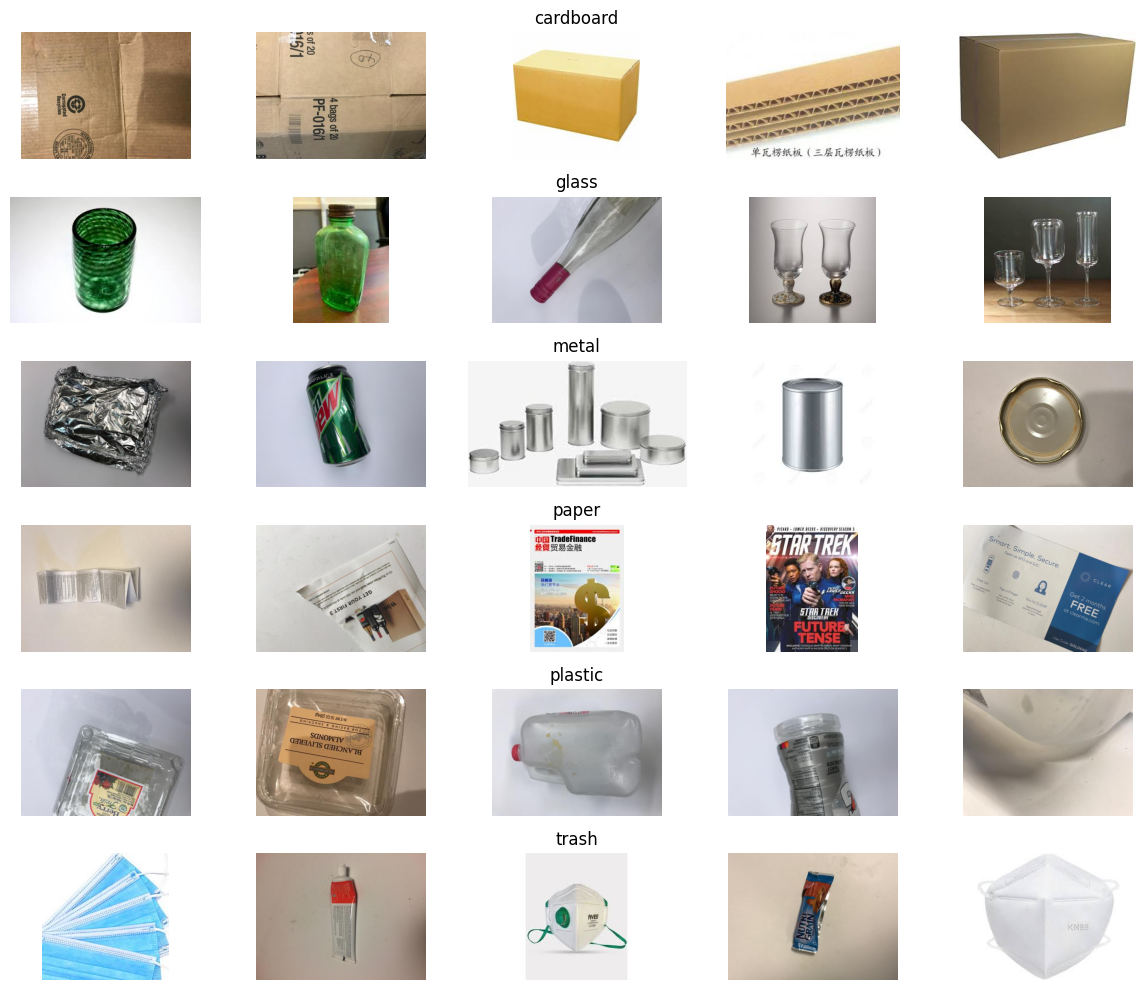

Image width range: 51 - 512
Image height range: 100 - 400


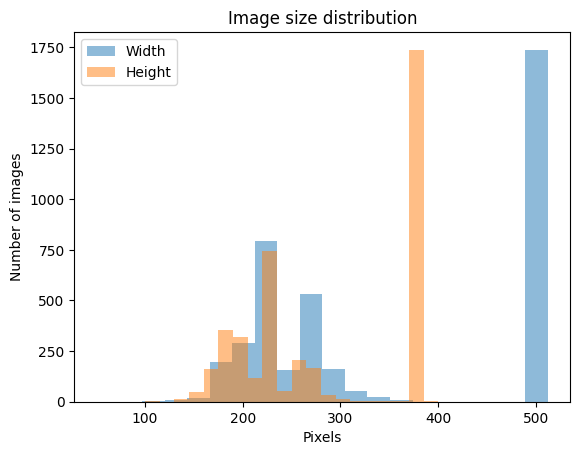

Color channels distribution: Counter({'RGB': 3973, 'P': 12})


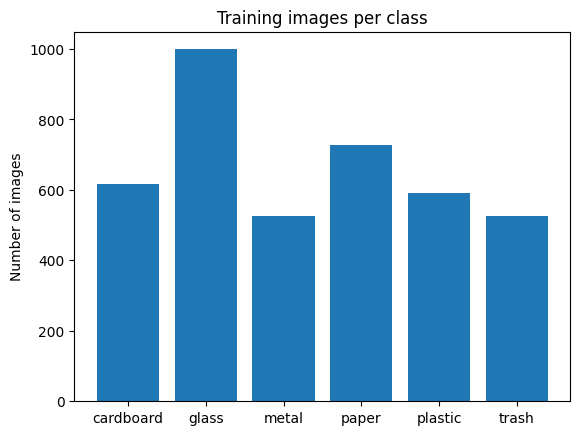

In [4]:
# EDA

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from pathlib import Path
from PIL import Image
import random
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

# Use your DataLoader paths
data_dir = Path(os.getenv("PROJECT_DIR")) / os.getenv("DATA_DIR")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

# Helper function to extract class from filename
def get_class(file_path):
    return file_path.name.split("_")[1]  # e.g., 'train_cardboard_014.jpg' -> 'cardboard'

# ----------------------------
# 1️⃣ Class counts
# ----------------------------
train_files = list(train_dir.glob("*.jpg"))
train_classes = [get_class(f) for f in train_files]
train_counts = Counter(train_classes)
print("Training class counts:", train_counts)

test_files = list(test_dir.glob("*.jpg"))
test_classes = [get_class(f) for f in test_files]
test_counts = Counter(test_classes)
print("Test class counts:", test_counts)

# ----------------------------
# 2️⃣ Sample images per class
# ----------------------------
classes = list(train_counts.keys())
fig, axes = plt.subplots(len(classes), 5, figsize=(12, 10))
for i, cls in enumerate(classes):
    cls_files = [f for f in train_files if get_class(f) == cls]
    for j, img_path in enumerate(random.sample(cls_files, min(5, len(cls_files)))):
        ax = axes[i, j]
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        if j == 2:
            ax.set_title(cls)
plt.tight_layout()
plt.show()

# ----------------------------
# 3️⃣ Image sizes
# ----------------------------
sizes = [Image.open(f).size for f in train_files]
widths, heights = zip(*sizes)
print(f"Image width range: {min(widths)} - {max(widths)}")
print(f"Image height range: {min(heights)} - {max(heights)}")

plt.hist(widths, bins=20, alpha=0.5, label="Width")
plt.hist(heights, bins=20, alpha=0.5, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.title("Image size distribution")
plt.legend()
plt.show()

# ----------------------------
# 4️⃣ Color channels check
# ----------------------------
modes = [Image.open(f).mode for f in train_files]
mode_counts = Counter(modes)
print("Color channels distribution:", mode_counts)

# ----------------------------
# 5️⃣ Class distribution bar chart
# ----------------------------
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training images per class")
plt.ylabel("Number of images")
plt.show()


In [ ]:
import math
import random
from pathlib import Path
from collections import Counter

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image

# ----------------------------
# 0) Perf toggles (safe on 3060 Ti)
# ----------------------------
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")  # TF32 on Ampere

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "Device:", device, flush=True)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0), flush=True)

# ----------------------------
# 1) Dataset
# ----------------------------
class MaterialDataset(torch.utils.data.Dataset):
    def __init__(self, folder: Path, transform=None):
        self.files = list(folder.glob("*.jpg"))
        self.transform = transform
        self.classes = sorted({f.name.split("_")[1] for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        img = Image.open(p).convert("RGB")
        label = self.class_to_idx[p.name.split("_")[1]]
        if self.transform:
            img = self.transform(img)
        return img, label

# ----------------------------
# 2) Transforms
# ----------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Keep a single train transform through stages (avoids distribution shift)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
    transforms.RandomGrayscale(p=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.15),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ----------------------------
# 3) Data (keep DataLoader simple because it works on your Windows setup)
# ----------------------------
data_dir = Path("../data")
train_dataset = MaterialDataset(data_dir / "train", transform_train)
test_dataset  = MaterialDataset(data_dir / "test", transform_test)

# With AMP you can often push this to 128 on a 3060 Ti; start with 96 as a good middle-ground
batch_size = 96
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=192, shuffle=False)

print("Train images:", len(train_dataset), "Test images:", len(test_dataset), flush=True)
print("Train batches/epoch:", len(train_loader), flush=True)
print("Classes:", train_dataset.classes, flush=True)

# ----------------------------
# 4) Model (upgrade for accuracy: ResNeXt50_32x4d is often > ResNet50)
# ----------------------------
# If you want maximum, swap to resnext101_32x8d (will be slower):
# model = models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2)
model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

num_classes = len(train_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)

# ----------------------------
# 5) Class weights (keep, but we’ll disable late if it caps peak)
# ----------------------------
train_labels = [f.name.split("_")[1] for f in train_dataset.files]
class_counts = Counter(train_labels)
weights = [1.0 / class_counts[c] for c in train_dataset.classes]
class_weights = torch.tensor(weights, dtype=torch.float, device=device)

# ----------------------------
# 6) Freeze/unfreeze plan
# ----------------------------
def freeze_all(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_module(m):
    for p in m.parameters():
        p.requires_grad = True

freeze_all(model)
unfreeze_module(model.fc)

# ----------------------------
# 7) AMP + cosine schedule + EMA
# ----------------------------
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.detach().clone() for n, p in model.named_parameters() if p.requires_grad}

    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if n in self.shadow:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)

    @torch.no_grad()
    def apply_to(self, model):
        self.backup = {}
        for n, p in model.named_parameters():
            if n in self.shadow:
                self.backup[n] = p.detach().clone()
                p.copy_(self.shadow[n])

    @torch.no_grad()
    def restore(self, model):
        for n, p in model.named_parameters():
            if n in getattr(self, "backup", {}):
                p.copy_(self.backup[n])
        self.backup = {}

def make_optimizer(lr, wd):
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.AdamW(params, lr=lr, weight_decay=wd)

def cosine_lr(step, total_steps, lr_max, lr_min):
    t = step / max(1, total_steps)
    return lr_min + 0.5 * (lr_max - lr_min) * (1.0 + math.cos(math.pi * t))

# ----------------------------
# 8) MixUp/CutMix (mild, only for fine-tune stages; can lift generalisation)
# ----------------------------
def rand_bbox(W, H, lam):
    cut_rat = math.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = random.randint(0, W)
    cy = random.randint(0, H)
    x1 = max(cx - cut_w // 2, 0)
    y1 = max(cy - cut_h // 2, 0)
    x2 = min(cx + cut_w // 2, W)
    y2 = min(cy + cut_h // 2, H)
    return x1, y1, x2, y2

def mixup_cutmix(images, targets, mixup_alpha=0.2, cutmix_alpha=0.6, p=0.35):
    if random.random() > p:
        return images, targets, targets, 1.0
    bs, _, H, W = images.size()
    perm = torch.randperm(bs, device=images.device)
    use_cutmix = random.random() < 0.5
    if use_cutmix:
        lam = torch.distributions.Beta(cutmix_alpha, cutmix_alpha).sample().item()
        x1, y1, x2, y2 = rand_bbox(W, H, lam)
        images2 = images[perm]
        images[:, :, y1:y2, x1:x2] = images2[:, :, y1:y2, x1:x2]
        lam = 1.0 - ((x2 - x1) * (y2 - y1) / (W * H))
    else:
        lam = torch.distributions.Beta(mixup_alpha, mixup_alpha).sample().item()
        images = images * lam + images[perm] * (1.0 - lam)
    ya, yb = targets, targets[perm]
    return images, ya, yb, lam

# ----------------------------
# 9) Eval with stronger TTA (flip + 5-crop) for max score
# ----------------------------
fivecrop = transforms.FiveCrop(224)

@torch.no_grad()
def evaluate_tta_strong():
    model.eval()
    correct, total = 0, 0
    for imgs, labels in test_loader:
        labels = labels.to(device)

        # imgs: [B, C, H, W] already normalized
        # Build 5 crops + their hflips => 10 views per image
        crops = fivecrop(imgs)  # tuple of 5 tensors [B,C,224,224]
        views = []
        for c in crops:
            views.append(c)
            views.append(torch.flip(c, dims=[3]))
        # Stack views: [10*B, C, 224, 224]
        v = torch.cat(views, dim=0).to(device)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(v)  # [10*B, num_classes]
        # reshape back to [10, B, num_classes] and average
        logits = logits.view(10, imgs.size(0), -1).mean(dim=0)

        preds = logits.argmax(1)
        correct += (preds.cpu() == labels.cpu()).sum().item()
        total += labels.size(0)
    return correct / total

# ----------------------------
# 10) Train loop helper (EMA + optional mix)
# ----------------------------
def train_stage(epochs, lr_max, lr_min_factor, wd, stage_name, criterion, use_mix):
    optimizer = make_optimizer(lr_max, wd)
    ema = EMA(model, decay=0.999)

    total_steps = epochs * len(train_loader)
    step = 0
    best = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            if use_mix:
                imgs2, ya, yb, lam = mixup_cutmix(imgs, labels, p=0.35)
            else:
                imgs2, ya, yb, lam = imgs, labels, labels, 1.0

            lr = cosine_lr(step, total_steps, lr_max=lr_max, lr_min=lr_max * lr_min_factor)
            for pg in optimizer.param_groups:
                pg["lr"] = lr

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(imgs2)
                loss = lam * criterion(outputs, ya) + (1.0 - lam) * criterion(outputs, yb)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            ema.update(model)

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            step += 1

        # Evaluate with EMA weights for stability
        ema.apply_to(model)
        acc = evaluate_tta_strong()  # strongest scoring (slower but max accuracy)
        ema.restore(model)

        loss_epoch = running_loss / max(1, total)
        train_acc = correct / max(1, total)

        if acc > best:
            best = acc
            torch.save({"model": model.state_dict(), "classes": train_dataset.classes}, f"best_{stage_name}.pt")

        print(
            f"[{stage_name} {epoch:02d}/{epochs}] "
            f"loss={loss_epoch:.4f} train_acc={train_acc:.4f} test_acc(TTA10)={acc:.4f} best={best:.4f}",
            flush=True
        )
    return best

# ----------------------------
# 11) Stages tuned for max accuracy
# ----------------------------

# Stage 1: head only, weights + smoothing (fast convergence)
criterion_head = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
best1 = train_stage(
    epochs=6, lr_max=2e-3, lr_min_factor=0.02, wd=0.02,
    stage_name="head", criterion=criterion_head, use_mix=False
)

# Stage 2: unfreeze layer4
unfreeze_module(model.layer4)
criterion_l4 = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
best2 = train_stage(
    epochs=12, lr_max=5e-4, lr_min_factor=0.02, wd=0.03,
    stage_name="layer4", criterion=criterion_l4, use_mix=True
)

# Stage 3: unfreeze layer3
unfreeze_module(model.layer3)
criterion_l3 = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.08)
best3 = train_stage(
    epochs=8, lr_max=2e-4, lr_min_factor=0.02, wd=0.05,
    stage_name="layer3", criterion=criterion_l3, use_mix=True
)

# Stage 4: FINAL POLISH @224
# Drop class weights (mild imbalance) + reduce smoothing + reduce WD + very low LR.
# This often recovers the last ~0.2–0.6% if weights/smoothing capped peak.
criterion_polish = nn.CrossEntropyLoss(label_smoothing=0.02)
best4 = train_stage(
    epochs=6, lr_max=8e-5, lr_min_factor=0.10, wd=0.015,
    stage_name="polish", criterion=criterion_polish, use_mix=False
)

print("Done. Bests:", best1, best2, best3, best4, flush=True)
print("Saved checkpoints: best_head.pt, best_layer4.pt, best_layer3.pt, best_polish.pt", flush=True)


CUDA: True Device: cuda
GPU: NVIDIA GeForce RTX 3060 Ti


Train images: 3985 Test images: 1704
Train batches/epoch: 42
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


C:\Users\jackb\AppData\Local\Temp\ipykernel_21872\1003323422.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
C:\Users\jackb\AppData\Local\Temp\ipykernel_21872\1003323422.py:256: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
C:\Users\jackb\AppData\Local\Temp\ipykernel_21872\1003323422.py:217: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
